# TRMM

The dataset used in this notebook is TRMM with daily values (from NASA). The data comes in separate files for each day and thus needs to be concatenated before processing.

Using the filter available on https://disc.gsfc.nasa.gov/SSW/#keywords=TRMM_3B42_Daily%207, the relevant geographical area can be extracted and the daily files downloaded. For the area, paste **5.125,62.375,39.875,97.125** to extract the exact spatial region used in the V. Stolbovas PhD thesis. For the variables, check only **precipitation** and subset the dataset.

If logged in with the earthdata account, the dataset can then be downloaded. Login can be found at https://urs.earthdata.nasa.gov/.

**Resources**

- Official TRMM README
- https://disc.gsfc.nasa.gov/datasets/TRMM_3B42_Daily_7/summary
- https://disc.gsfc.nasa.gov/SSW/#keywords=TRMM_3B42_Daily%207
- https://disc2.gesdisc.eosdis.nasa.gov/opendap/TRMM_L3/TRMM_3B42_Daily.7/
- https://disc.gsfc.nasa.gov/SSW/SSW_URL_List_Downloading_Instructions.html
- https://wiki.earthdata.nasa.gov/display/HDD/Wget+with+URS+Authentication#WgetwithURSAuthentication-Step-by-stepguide

**Citation**

Goddard Earth Sciences Data and Information Services Center(2016), TRMM (TMPA) Precipitation L3 1 day 0.25 degree x 0.25 degree V7, , Goddard Earth Sciences Data and Information Services Center (GES DISC), Accessed [21.08.2017] https://disc.gsfc.nasa.gov/datacollection/TRMM_3B42_Daily_7.html


61.75,4.5,97.75,40.5
- https://giovanni.gsfc.nasa.gov/giovanni/#service=TmAvMp&starttime=1997-12-31T00:00:00Z&endtime=2017-09-29T23:59:59Z&bbox=61.75,4.5,97.75,40.5&data=TRMM_3B42_Daily_7_precipitation&dataKeyword=trmm
- https://disc.sci.gsfc.nasa.gov/datasets?page=1&keywords=TRMM%203B42&start=1920-01-01&end=2016-06-27
- https://disc.sci.gsfc.nasa.gov/data-access

## Dependencies

To get all the dependencies needed for this project, import the corresponding conda environment file:
- **conda-gpu.env** for Tensorflow with GPU support
- **conda.env** for Tensorflow without GPU support

In [2]:
# statistical libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

# visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly
import plotly.plotly as py
from plotly.graph_objs import Scatter, Layout
import cartopy.crs as ccrs

# import own library functionality
import paths
from TRMM import TRMM
from Visualization import Visualization

# force autoreload of external modules on save
%load_ext autoreload
%autoreload 2
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

## Load the dataset

In [3]:
# how many years to load data for
# cannot yet use 2017 as the data for december is not complete
# TODO: extend with 2018 as soon as data is available
YEARS = range(1998, 2017)

# pre-monsoon period
MAM = [3, 4, 5]

# monsoon period
JJAS = [6, 7, 8, 9]

# post-monsoon period
OND = [10, 11, 12]

# run the aggregation algorithm over the dataframes?
# the resulting dataframe would be exorbitantly big otherwise
AGGREGATION_RESOLUTION = 0.75

In [ ]:
# load data for the pre-monsoon period (MAM)

mam_df = TRMM.load_dataset(
    YEARS,
    MAM,
    aggregation_resolution=AGGREGATION_RESOLUTION,
    timestamp=True,
    invalidate=False,
    lon_slice=slice(61.125, 97.625),
    lat_slice=slice(4.125, 40.625),
    version='v3')

In [4]:
# load data for the monsoon period (JJAS)

jjas_df = TRMM.load_dataset(
    YEARS,
    JJAS,
    aggregation_resolution=AGGREGATION_RESOLUTION,
    timestamp=True,
    invalidate=False,
    lon_slice=slice(61.125, 97.625),
    lat_slice=slice(4.125, 40.625),
    version='v3')

> Loading from cache...


In [5]:
# load data for the post-monsoon period (OND)

ond_df = TRMM.load_dataset(
    YEARS,
    OND,
    aggregation_resolution=AGGREGATION_RESOLUTION,
    timestamp=True,
    invalidate=False,
    lon_slice=slice(61.125, 97.625),
    lat_slice=slice(4.125, 40.625),
    version='v3')

> Loading from cache...


## Exploratory Data Analysis

In [69]:
important_locations = mam_df.loc[[(13.375, 67.375), (16.375, 91.375), (34.375, 88.375), (34.375, 67.375)]]
important_locations

888710400  888796800  888883200  888969600  889056000  \
latitude longitude                                                          
13.375   67.375      0.000000   0.000000   0.000000      0.000        0.0   
16.375   91.375      0.000000   0.000000   0.000000      0.000        0.0   
34.375   88.375      0.522000   0.000000  29.939999      0.156        0.0   
         67.375      0.862779  20.669221   0.000000      0.000        0.0   

                    889142400  889228800  889315200  889401600  889488000  \
latitude longitude                                                          
13.375   67.375         0.000        0.0        0.0       0.00        0.0   
16.375   91.375         0.000        0.0        0.0       2.49        0.0   
34.375   88.375         1.548        0.0        0.0       0.00        0.0   
         67.375         0.000        0.0        0.0       0.00        0.0   

                      ...       927331200   927417600   927504000   927590400  \
latitude longitude    ...                                                       
13.375   67.375       ...      218.549995  445.560005  202.440001   41.759999   
16.375   91.375       ...       31.049999   70.109997  162.479998  144.419997   
34.375   88.375       ...        0.000000    0.094336    6.097816    0.151781   
         67.375       ...        5.964000    0.732000    0.426000    0.420000   

                     927676800   927763200   927849600  927936000  928022400  \
latitude longitude                                                             
13.375   67.375      18.720000   13.830000    0.990000   6.210000      1.650   
16.375   91.375     603.599998  202.109996  179.609992   5.430000      4.050   
34.375   88.375       0.080860    0.000000    0.000000   0.007014      0.000   
         67.375       0.546000    0.474000    0.882000   0.930000      0.996   

                    928108800  
latitude longitude             
13.375   67.375       3.90000  
16.375   91.375      17.55000  
34.375   88.375       0.04588  
         67.375       0.07800  

[4 rows x 184 columns]

In [70]:
important_quantiles = important_locations.quantile(0.9, axis=1)
important_quantiles

latitude  longitude
13.375    67.375        2.688000
16.375    91.375       73.616998
34.375    88.375        6.871393
          67.375       28.869505
Name: 0.9, dtype: float64

In [98]:
important_ee = TRMM.extract_extreme_events(important_locations, quantile=0.9)
important_ee.iloc[3][important_ee.iloc[3] == True]

0               True
890179200       True
891216000       True
891302400       True
891388800       True
891734400       True
892944000       True
893203200       True
893289600       True
893376000       True
893462400       True
893980800       True
894067200       True
896486400       True
896572800       True
923443200       True
923529600       True
923616000       True
925862400       True
925948800       True
999999999999    True
Name: (34.375, 67.375), dtype: bool

In [ ]:
888883200, 890179200, 891129600, 891216000, 891302400, 891388800, 891475200, 891561600, 891734400, 891907200, 892080000, 892944000, 893203200

### Pre-Monsoon (MAM)

In [6]:
mam_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2401 entries, (4.375, 61.375) to (40.375, 97.375)
Columns: 1748 entries, 888710400 to 1464652800
dtypes: float64(1748)
memory usage: 32.0 MB


In [45]:
mam_df.tail()

1998-03-01 00:00:00+00:00  1998-03-02 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                           0.0                   0.161115   
         95.125                           0.0                   0.516471   
         95.875                           0.0                   0.000000   
         96.625                           0.0                   0.000000   
         97.375                           0.0                   0.000000   

                    1998-03-03 00:00:00+00:00  1998-03-04 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                      0.000000                   0.000000   
         95.125                      0.000000                   0.136527   
         95.875                      0.000000                   0.000000   
         96.625                      2.217927                   0.000000   
         97.375                      1.022686                   0.000000   

                    1998-03-05 00:00:00+00:00  1998-03-06 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                           0.0                   0.000000   
         95.125                           0.0                   0.000000   
         95.875                           0.0                   0.000000   
         96.625                           0.0                   1.068078   
         97.375                           0.0                  13.621249   

                    1998-03-07 00:00:00+00:00  1998-03-08 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                      0.256137                        0.0   
         95.125                      2.921605                        0.0   
         95.875                      4.283582                        0.0   
         96.625                      0.000000                        0.0   
         97.375                      1.471204                        0.0   

                    1998-03-09 00:00:00+00:00  1998-03-10 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                           0.0                        0.0   
         95.125                           0.0                        0.0   
         95.875                           0.0                        0.0   
         96.625                           0.0                        0.0   
         97.375                           0.0                        0.0   

                              ...              1999-05-22 00:00:00+00:00  \
latitude longitude            ...                                          
40.375   94.375               ...                                    0.0   
         95.125               ...                                    0.0   
         95.875               ...                                    0.0   
         96.625               ...                                    0.0   
         97.375               ...                                    0.0   

                    1999-05-23 00:00:00+00:00  1999-05-24 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                      0.000000                        0.0   
         95.125                      0.000000                        0.0   
         95.875                      0.000000                        0.0   
         96.625                      2.434592                        0.0   
         97.375                      0.000000                        0.0   

                    1999-05-25 00:00:00+00:00  1999-05-26 00:00:00+00:00  \
latitude longitude                                                         
40.375   94.375                           0.0                        0.0   
         95.125                           0.0                

In [8]:
mam_df.unstack(-1).iloc[:5, :5]

888710400                            
longitude    61.375 62.125 62.875 63.625 64.375
latitude                                       
4.375           0.0   5.37   4.02   4.35   0.54
5.125           0.0   0.00   0.00   0.00   1.56
5.875           0.0   0.00   0.00   0.00   0.00
6.625           0.0   0.00   0.00   0.00   0.00
7.375           0.0   0.00   0.00   0.00   0.00

In [46]:
mam_df.iloc[0].quantile(0.9)

124.60499377250682

### Monsoon (JJAS)

In [10]:
jjas_df.tail()

896659200   896745600   896832000   896918400   \
latitude longitude                                                   
40.375   94.375            0.0         0.0         0.0         0.0   
         95.125            0.0         0.0         0.0         0.0   
         95.875            0.0         0.0         0.0         0.0   
         96.625            0.0         0.0         0.0         0.0   
         97.375            0.0         0.0         0.0         0.0   

                    897004800   897091200   897177600   897264000   \
latitude longitude                                                   
40.375   94.375       1.141729    0.000000         0.0         0.0   
         95.125       6.051924    0.000000         0.0         0.0   
         95.875      15.563477    0.000000         0.0         0.0   
         96.625      16.951041    0.115731         0.0         0.0   
         97.375      11.179539    1.619584         0.0         0.0   

                    897350400   897436800      ...      1474416000  \
latitude longitude                             ...                   
40.375   94.375       2.221119    0.000000     ...             0.0   
         95.125       7.571684    0.000000     ...             0.0   
         95.875       5.265064    3.535445     ...             0.0   
         96.625       7.605862    4.686966     ...             0.0   
         97.375       7.397860   20.376898     ...             0.0   

                    1474502400  1474588800  1474675200  1474761600  \
latitude longitude                                                   
40.375   94.375            0.0         0.0         0.0         0.0   
         95.125            0.0         0.0         0.0         0.0   
         95.875            0.0         0.0         0.0         0.0   
         96.625            0.0         0.0         0.0         0.0   
         97.375            0.0         0.0         0.0         0.0   

                    1474848000  1474934400  1475020800  1475107200  1475193600  
latitude longitude                                                              
40.375   94.375       0.000000         0.0         0.0         0.0         0.0  
         95.125       0.180000         0.0         0.0         0.0         0.0  
         95.875       0.360000         0.0         0.0         0.0         0.0  
         96.625       0.000000         0.0         0.0         0.0         0.0  
         97.375       1.067942         0.0         0.0         0.0         0.0  

[5 rows x 2318 columns]

In [11]:
jjas_df.unstack(-1).iloc[:5, :5]

896659200                            
longitude    61.375 62.125 62.875 63.625 64.375
latitude                                       
4.375          0.00   0.00   0.03   0.18   0.00
5.125          0.18   0.00   2.49   0.00   0.48
5.875          0.24   0.87   1.59   0.00   0.81
6.625          0.03   0.54   0.99   2.31   6.60
7.375          0.00   0.90   0.18   1.83   1.26

In [12]:
jjas_df.iloc[0].quantile(0.9)

78.44699873924257

### Post-Monsoon (OND)

In [13]:
ond_df.tail()

907200000   907286400   907372800   907459200   \
latitude longitude                                                   
40.375   94.375            0.0         0.0         0.0         0.0   
         95.125            0.0         0.0         0.0         0.0   
         95.875            0.0         0.0         0.0         0.0   
         96.625            0.0         0.0         0.0         0.0   
         97.375            0.0         0.0         0.0         0.0   

                    907545600   907632000   907718400   907804800   \
latitude longitude                                                   
40.375   94.375            0.0         0.0         0.0         0.0   
         95.125            0.0         0.0         0.0         0.0   
         95.875            0.0         0.0         0.0         0.0   
         96.625            0.0         0.0         0.0         0.0   
         97.375            0.0         0.0         0.0         0.0   

                    907891200   907977600      ...      1482364800  \
latitude longitude                             ...                   
40.375   94.375            0.0       0.000     ...             0.0   
         95.125            0.0       1.152     ...             0.0   
         95.875            0.0       3.582     ...             0.0   
         96.625            0.0       1.218     ...             0.0   
         97.375            0.0       0.756     ...             0.0   

                    1482451200  1482537600  1482624000  1482710400  \
latitude longitude                                                   
40.375   94.375       4.914773         0.0         0.0         0.0   
         95.125       0.749344         0.0         0.0         0.0   
         95.875       0.000000         0.0         0.0         0.0   
         96.625       0.000000         0.0         0.0         0.0   
         97.375       0.000000         0.0         0.0         0.0   

                    1482796800  1482883200  1482969600  1483056000  1483142400  
latitude longitude                                                              
40.375   94.375            0.0         0.0         0.0         0.0         0.0  
         95.125            0.0         0.0         0.0         0.0         0.0  
         95.875            0.0         0.0         0.0         0.0         0.0  
         96.625            0.0         0.0         0.0         0.0         0.0  
         97.375            0.0         0.0         0.0         0.0         0.0  

[5 rows x 1748 columns]

In [14]:
ond_df.unstack(-1).iloc[:5, :5]

907200000                                               
longitude     61.375     62.125      62.875      63.625      64.375
latitude                                                           
4.375      28.890000  18.209999   81.119998  130.979993  138.509996
5.125      32.309999  50.159998  102.479995  103.859995   54.359998
5.875      12.330000  46.919999   71.399997   72.089999   69.029996
6.625       3.360000   7.230000   24.150000   72.299999   58.860000
7.375       0.000000   0.120000    0.240000    6.210000   20.910000

In [15]:
ond_df.iloc[0].quantile(0.9)

144.0569965839386

## Extraction of Extreme Events

Events are regarded as extreme events if they fall above the 90% quantile of the entire time-series.

In [100]:
EE_QUANTILE = 0.9

### Pre-Monsoon (MAM)

In [101]:
# extract extreme events from the dataset
# results in a matrix of boolean values for Extreme/Non-Extreme

mam_extreme_events = TRMM.extract_extreme_events(mam_df, quantile=EE_QUANTILE)
mam_extreme_events.head()

0             888710400     888796800     888883200     \
latitude longitude                                                           
4.375    61.375             True         False         False         False   
         62.125             True         False         False         False   
         62.875             True         False         False         False   
         63.625             True         False         False         False   
         64.375             True         False         False         False   

                    888969600     889056000     889142400     889228800     \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    889315200     889401600         ...       927417600     \
latitude longitude                                  ...                      
4.375    61.375            False         False      ...              False   
         62.125            False         False      ...              False   
         62.875            False         False      ...              False   
         63.625            False         False      ...              False   
         64.375            False         False      ...              False   

                    927504000     927590400     927676800     927763200     \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    927849600     927936000     928022400     928108800     \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    999999999999  
latitude longitude                
4.375    61.375             True  
         62.125             True  
         62.875             True  
         63.625             True  
         64.375             True  

[5 rows x 186 columns]

In [102]:
# print only the events that are extreme for the very first row

mam_extreme_events.iloc[0][mam_extreme_events.iloc[0]].head()

0            True
890265600    True
891043200    True
891216000    True
892684800    True
Name: (4.375, 61.375), dtype: bool

### Monsoon (JJAS)

In [19]:
# calculate extreme events for JJAS

jjas_extreme_events = TRMM.extract_extreme_events(jjas_df, quantile=EE_QUANTILE)
jjas_extreme_events.head()

0             896659200     896745600     896832000     \
latitude longitude                                                           
4.375    61.375             True         False         False         False   
         62.125             True         False         False         False   
         62.875             True         False         False         False   
         63.625             True         False         False         False   
         64.375             True         False         False         False   

                    896918400     897004800     897091200     897177600     \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    897264000     897350400         ...       1474502400    \
latitude longitude                                  ...                      
4.375    61.375            False         False      ...              False   
         62.125            False         False      ...              False   
         62.875            False         False      ...              False   
         63.625            False         False      ...              False   
         64.375            False         False      ...              False   

                    1474588800    1474675200    1474761600    1474848000    \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    1474934400    1475020800    1475107200    1475193600    \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    999999999999  
latitude longitude                
4.375    61.375             True  
         62.125             True  
         62.875             True  
         63.625             True  
         64.375             True  

[5 rows x 2320 columns]

In [20]:
# print only the events that are extreme for the very first row

jjas_extreme_events.iloc[0][jjas_extreme_events.iloc[0]].head()

0            True
898732800    True
898819200    True
899078400    True
899164800    True
Name: (4.375, 61.375), dtype: bool

### Post-Monsoon (OND)

In [21]:
# calculate extreme events for OND

ond_extreme_events = TRMM.extract_extreme_events(ond_df, quantile=EE_QUANTILE)
ond_extreme_events.head()

0             907200000     907286400     907372800     \
latitude longitude                                                           
4.375    61.375             True         False          True         False   
         62.125             True         False          True         False   
         62.875             True         False          True         False   
         63.625             True         False          True          True   
         64.375             True         False          True         False   

                    907459200     907545600     907632000     907718400     \
latitude longitude                                                           
4.375    61.375            False         False          True          True   
         62.125            False         False          True          True   
         62.875            False         False         False          True   
         63.625            False         False         False          True   
         64.375            False         False         False          True   

                    907804800     907891200         ...       1482451200    \
latitude longitude                                  ...                      
4.375    61.375            False         False      ...              False   
         62.125            False         False      ...              False   
         62.875            False         False      ...              False   
         63.625            False         False      ...              False   
         64.375            False         False      ...              False   

                    1482537600    1482624000    1482710400    1482796800    \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    1482883200    1482969600    1483056000    1483142400    \
latitude longitude                                                           
4.375    61.375            False         False         False         False   
         62.125            False         False         False         False   
         62.875            False         False         False         False   
         63.625            False         False         False         False   
         64.375            False         False         False         False   

                    999999999999  
latitude longitude                
4.375    61.375             True  
         62.125             True  
         62.875             True  
         63.625             True  
         64.375             True  

[5 rows x 1750 columns]

In [22]:
# print only the events that are extreme for the very first row
ond_extreme_events.iloc[0][ond_extreme_events.iloc[0]].head()

0            True
907286400    True
907632000    True
907718400    True
908496000    True
Name: (4.375, 61.375), dtype: bool

## Calculating Event Synchronization

For each pair of grid cells, the level of synchronization in extreme events should be calculated.

### Pre-Monsoon (MAM)

In [119]:
# calculate the synchronization matrix

mam_sync_matrix, mam_count_matrix, mam_runtime = TRMM.parallel_calculate_sync_matrix(mam_extreme_events, f'MAM-{EE_QUANTILE}')
mam_sync_matrix.iloc[:5, :5]

> Loading from cache...


latitude               4.375                                        
longitude             61.375    62.125    62.875    63.625    64.375
latitude longitude                                                  
4.375    61.375     1.000000  0.748571  0.622857  0.588571  0.560000
         62.125     0.748571  1.000000  0.771429  0.662857  0.628571
         62.875     0.622857  0.771429  1.000000  0.748571  0.668571
         63.625     0.588571  0.662857  0.748571  1.000000  0.760000
         64.375     0.560000  0.628571  0.668571  0.760000  1.000000

In [120]:
mam_sync_matrix.isna().sum().sum()

0

In [121]:
mam_sync_matrix.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2401 entries, (4.375, 61.375) to (40.375, 97.375)
Columns: 2401 entries, (4.375, 61.375) to (40.375, 97.375)
dtypes: float32(2401)
memory usage: 22.1 MB


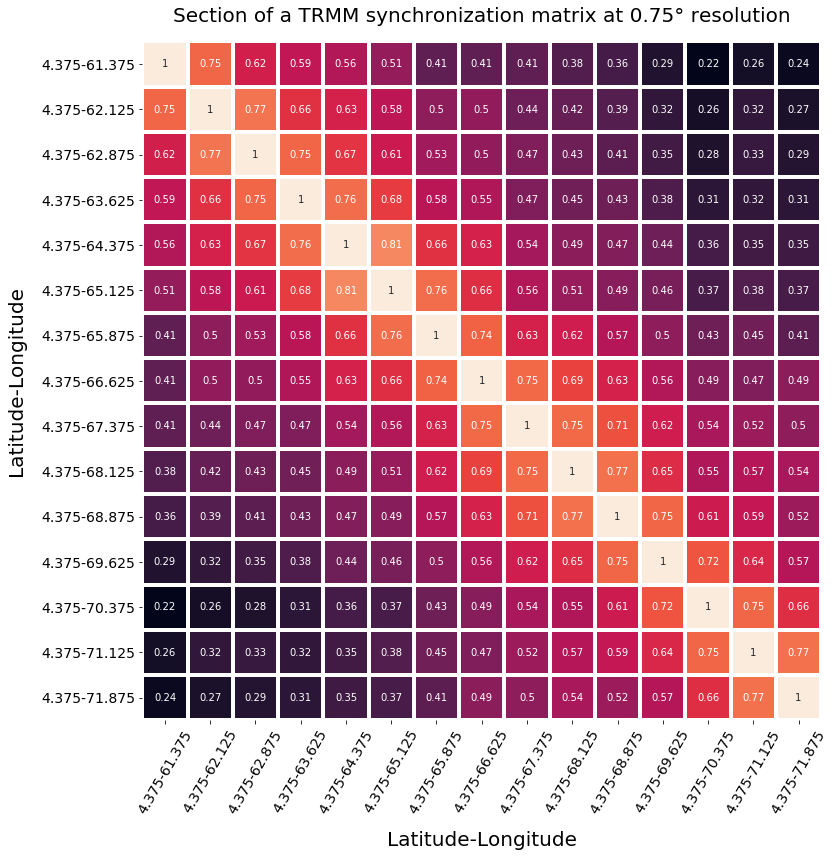

In [248]:
example_matrix = mam_sync_matrix.iloc[:15, :15].copy()

fig = plt.figure(figsize=(12, 12))
# cbar_kws=dict(fraction=0.046, pad=0.04, label='Strength of synchronization')
ax = sns.heatmap(example_matrix, square=True, annot=True, cbar=False, linewidths=3)

ax.set_ylabel('Latitude-Longitude', size=20, labelpad=15)
ax.set_xlabel('Latitude-Longitude', size=20, labelpad=15)
ax.set_xmargin(0)
ax.set_ymargin(0)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14, rotation=0)
ax.autoscale_view()
ttl = ax.set_title('Section of a TRMM synchronization matrix at 0.75° resolution', size=20)
ttl.set_position([0.5, 1.02])
plt.tight_layout()
plt.savefig('output/trmm_sync_example.png', bbox_inches='tight')

In [249]:
np.fill_diagonal(example_matrix.values, np.nan)
gt = np.nanpercentile(example_matrix, 80)
gt

0.65714287757873535

In [250]:
np.fill_diagonal(example_matrix.values, 0)
example_matrix[example_matrix < gt] = 0
example_matrix[example_matrix >= gt] = 1

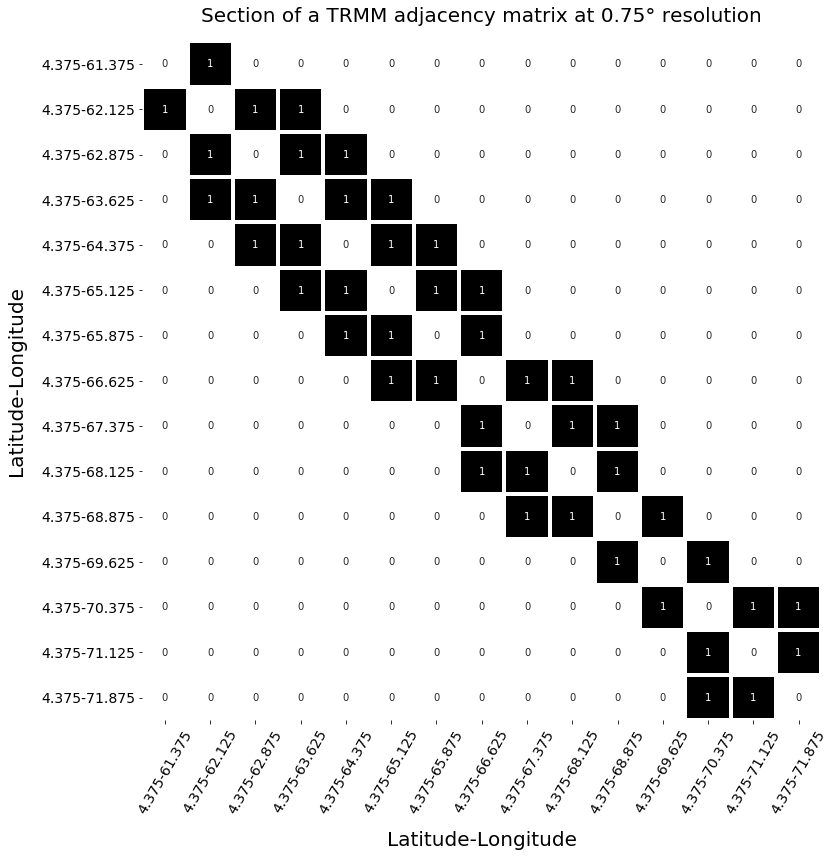

In [255]:
fig = plt.figure(figsize=(12, 12))
# cbar_kws=dict(fraction=0.046, pad=0.04, label='Strength of synchronization')
ax = sns.heatmap(example_matrix, square=True, annot=True, cbar=False, linewidths=3, cmap='binary')
ax.set_ylabel('Latitude-Longitude', size=20, labelpad=15)
ax.set_xlabel('Latitude-Longitude', size=20, labelpad=15)
ax.set_xmargin(0)
ax.set_ymargin(0)
plt.xticks(fontsize=14, rotation=60)
plt.yticks(fontsize=14, rotation=0)
ax.autoscale_view()
ttl = ax.set_title('Section of a TRMM adjacency matrix at 0.75° resolution', size=20)
ttl.set_position([0.5, 1.02])
plt.tight_layout()

plt.savefig('output/trmm_adjacency_example.png', bbox_inches='tight')

### Monsoon (JJAS)

In [25]:
# calculate sync and count matrices for JJAS

jjas_sync_matrix, jjas_count_matrix, jjas_runtime = TRMM.calculate_sync_matrix(jjas_extreme_events, f'JJAS-{EE_QUANTILE}')
jjas_sync_matrix.iloc[:5, :5]

> Loading from cache...


latitude               4.375                                        
longitude             61.375    62.125    62.875    63.625    64.375
latitude longitude                                                  
4.375    61.375     1.000000  0.758621  0.637931  0.543103  0.504310
         62.125     0.758621  1.000000  0.775862  0.650862  0.586207
         62.875     0.637931  0.775862  1.000000  0.750000  0.650862
         63.625     0.543103  0.650862  0.750000  1.000000  0.784483
         64.375     0.504310  0.586207  0.650862  0.784483  1.000000

In [26]:
jjas_sync_matrix.isna().sum().sum()

0

In [107]:
fig = plt.figure(figsize=(15, 15))
sns.heatmap(mam_sync_matrix - jjas_sync_matrix)

NameError: name 'jjas_sync_matrix' is not defined

### Post-Monsoon (OND)

In [28]:
# calculate sync and count matrices for OND

ond_sync_matrix, ond_count_matrix, ond_runtime = TRMM.calculate_sync_matrix(ond_extreme_events, f'OND-{EE_QUANTILE}')
ond_sync_matrix.iloc[:5, :5]

> Loading from cache...


latitude               4.375                                        
longitude             61.375    62.125    62.875    63.625    64.375
latitude longitude                                                  
4.375    61.375     1.000000  0.760000  0.645714  0.554286  0.485714
         62.125     0.760000  1.000000  0.748571  0.657143  0.542857
         62.875     0.645714  0.748571  1.000000  0.777143  0.628571
         63.625     0.554286  0.657143  0.777143  1.000000  0.760000
         64.375     0.485714  0.542857  0.628571  0.760000  1.000000

In [29]:
ond_sync_matrix.isna().sum().sum()

0

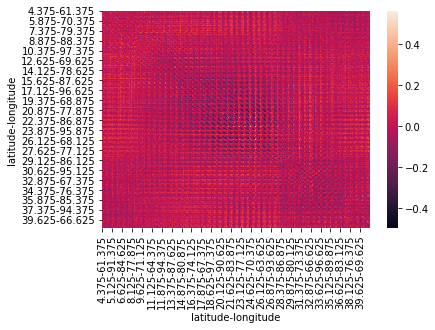

In [30]:
sns.heatmap(jjas_sync_matrix - ond_sync_matrix)

## Building a Climate Network

Generate a graph representation from the above count matrix. Only draw edges for values above the specified quantile.

In [31]:
NETWORK_QUANTILE = 0.9

### Pre-Monsoon (MAM)

In [32]:
mam_graph_counts = TRMM.generate_graph(mam_count_matrix, quantile=NETWORK_QUANTILE)
print(len(mam_graph_counts.nodes), len(mam_graph_counts.edges))
print(np.mean([d['weight'] for (x, y, d) in mam_graph_counts.edges(data=True)]))

2401 276015
1.0


In [33]:
mam_graph_counts_w = TRMM.generate_graph(mam_count_matrix, quantile=NETWORK_QUANTILE, set_ge=None)
print(len(mam_graph_counts_w.nodes), len(mam_graph_counts_w.edges))
print(np.mean([d['weight'] for (x, y, d) in mam_graph_counts_w.edges(data=True)]))

2401 276015
65.7545785555


In [34]:
mam_graph = TRMM.generate_graph(mam_sync_matrix, quantile=NETWORK_QUANTILE)
print(len(mam_graph.nodes), len(mam_graph.edges))
print(np.mean([d['weight'] for (x, y, d) in mam_graph.edges(data=True)]))

2401 286888
1.0


In [35]:
mam_graph_w = TRMM.generate_graph(mam_sync_matrix, quantile=NETWORK_QUANTILE, set_ge=None)
print(len(mam_graph_w.nodes), len(mam_graph_w.edges))
print(np.mean([d['weight'] for (x, y, d) in mam_graph_w.edges(data=True)]))

2401 286888
0.375100773403


In [36]:
mam_cent_degree, mam_cent_between, mam_pagerank = TRMM.calculate_centrality(mam_graph)

In [37]:
mam_cent_degree_w, mam_cent_between_w, mam_pagerank_w = TRMM.calculate_centrality(mam_graph_w, weighted=True)

#### Degree

In [38]:
mam_cent_degree.head(3)

,lat,lon,val,text,val_0to1,val_std
0,4.375,61.375,67,"(4.375, 61.375)=67.0000",0.106713,-1.591646
1,4.375,62.125,79,"(4.375, 62.125)=79.0000",0.127367,-1.480584
2,4.375,62.875,91,"(4.375, 62.875)=91.0000",0.148021,-1.369522


In [39]:
mam_cent_degree_w.head(3)

,lat,lon,val,text,val_0to1,val_std
0,4.375,61.375,27.651429,"(4.375, 61.375)=27.6514",0.104894,-1.416293
1,4.375,62.125,32.885714,"(4.375, 62.125)=32.8857",0.125943,-1.296701
2,4.375,62.875,37.274286,"(4.375, 62.875)=37.2743",0.143592,-1.196431


In [40]:
mam_cent_degree.pivot(index='lat', columns='lon', values='val').iloc[:5, :5]

lon,61.375,62.125,62.875,63.625,64.375
lat,,,,,
4.375,67,79,91,92,109
5.125,68,73,103,107,112
5.875,92,92,118,113,136
6.625,125,143,149,197,172
7.375,145,198,197,234,268


In [41]:
mam_cent_degree[['val', 'val_std']].describe()

,val,val_std
count,2401.000000,2.401000e+03
mean,238.973761,1.080167e-16
std,108.047720,1.000000e+00
min,5.000000,-2.165467e+00
25%,165.000000,-6.846397e-01
50%,220.000000,-1.756054e-01
75%,279.000000,3.704496e-01
max,586.000000,3.211787e+00


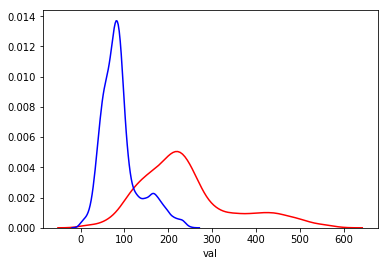

In [42]:
sns.distplot(mam_cent_degree['val'], hist=False, color='r')
sns.distplot(mam_cent_degree_w['val'], hist=False, color='b')

#### Betweenness

In [43]:
mam_cent_between.head(3)

,lat,lon,val,text,val_0to1,val_std
0,4.375,61.375,659.169077,"(4.375, 61.375)=659.1691",0.019446,-0.406616
1,4.375,62.125,119.065396,"(4.375, 62.125)=119.0654",0.003502,-0.597062
2,4.375,62.875,237.539529,"(4.375, 62.875)=237.5395",0.006999,-0.555287


In [180]:
mam_cent_between_w.head(3)

,lat,lon,val,text,val_0to1,val_std
0,4.375,61.375,486.340079,"(4.375, 61.375)=486.3401",0.013591,-0.518394
1,4.375,62.125,46.816667,"(4.375, 62.125)=46.8167",0.001308,-0.688739
2,4.375,62.875,148.741667,"(4.375, 62.875)=148.7417",0.004157,-0.649236


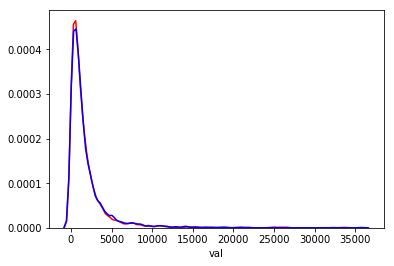

In [184]:
sns.distplot(mam_cent_between['val'], hist=False, color='r')
sns.distplot(mam_cent_between_w['val'], hist=False, color='b')

#### PageRank

In [46]:
mam_pagerank.head(3)

,lat,lon,val,text,val_0to1,val_std
0,4.375,61.375,0.000162,"(4.375, 61.375)=0.0002",0.112859,-2.128658
1,4.375,62.125,0.000177,"(4.375, 62.125)=0.0002",0.135110,-1.999291
2,4.375,62.875,0.000193,"(4.375, 62.875)=0.0002",0.157667,-1.868147


In [47]:
mam_pagerank_w.head(3)

,lat,lon,val,text,val_0to1,val_std
0,4.375,61.375,0.000171,"(4.375, 61.375)=0.0002",0.114173,-2.022262
1,4.375,62.125,0.000190,"(4.375, 62.125)=0.0002",0.138758,-1.869189
2,4.375,62.875,0.000204,"(4.375, 62.875)=0.0002",0.158322,-1.747378


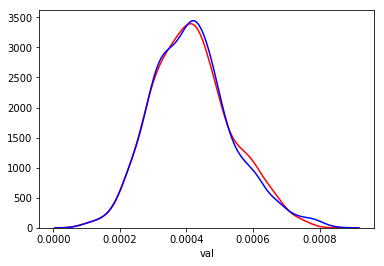

In [48]:
sns.distplot(mam_pagerank['val'], hist=False, color='r')
sns.distplot(mam_pagerank_w['val'], hist=False, color='b')

### Monsoon (JJAS)

In [49]:
jjas_graph = TRMM.generate_graph(jjas_sync_matrix, quantile=NETWORK_QUANTILE)
print(len(jjas_graph.nodes), len(jjas_graph.edges))
print(np.mean([d['weight'] for (x, y, d) in jjas_graph.edges(data=True)]))

2401 288120
1.0


In [50]:
jjas_graph_w = TRMM.generate_graph(jjas_sync_matrix, quantile=NETWORK_QUANTILE, set_ge=None)
print(len(jjas_graph_w.nodes), len(jjas_graph_w.edges))
print(np.mean([d['weight'] for (x, y, d) in jjas_graph_w.edges(data=True)]))

2401 288120
0.311414286415


In [51]:
jjas_cent_degree, jjas_cent_between, jjas_pagerank = TRMM.calculate_centrality(jjas_graph)

In [52]:
jjas_cent_degree_w, jjas_cent_between_w, jjas_pagerank_w = TRMM.calculate_centrality(jjas_graph_w, weighted=True)

### Post-Monsoon (OND)

In [53]:
ond_graph = TRMM.generate_graph(ond_sync_matrix, quantile=NETWORK_QUANTILE)
print(len(ond_graph.nodes), len(ond_graph.edges))
print(np.mean([d['weight'] for (x, y, d) in ond_graph.edges(data=True)]))

2401 282060
1.0


In [54]:
ond_graph_w = TRMM.generate_graph(ond_sync_matrix, quantile=NETWORK_QUANTILE, set_ge=None)
print(len(ond_graph_w.nodes), len(ond_graph_w.edges))
print(np.mean([d['weight'] for (x, y, d) in ond_graph_w.edges(data=True)]))

2401 282060
0.372744138272


In [55]:
ond_cent_degree, ond_cent_between, ond_pagerank = TRMM.calculate_centrality(ond_graph)

In [56]:
ond_cent_degree_w, ond_cent_between_w, ond_pagerank_w = TRMM.calculate_centrality(ond_graph_w, weighted=True)

### Overview

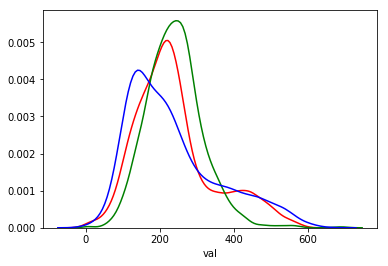

In [57]:
sns.distplot(mam_cent_degree['val'], hist=False, color='r')
sns.distplot(jjas_cent_degree['val'], hist=False, color='g')
sns.distplot(ond_cent_degree['val'], hist=False, color='b')

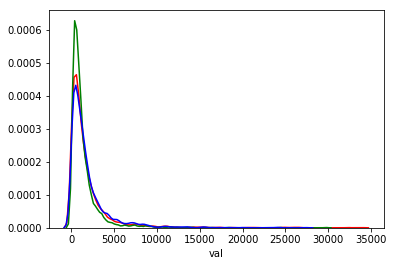

In [206]:
sns.distplot(mam_cent_between['val'], hist=False, color='r')
sns.distplot(jjas_cent_between['val'], hist=False, color='g')
sns.distplot(ond_cent_between['val'], hist=False, color='b')

C:\tools\Anaconda3\envs\bsc-thesis\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log10

C:\tools\Anaconda3\envs\bsc-thesis\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log10



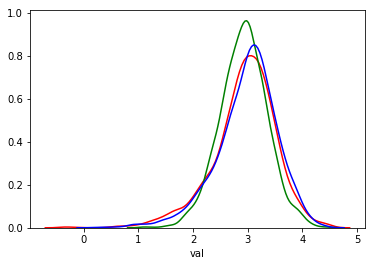

In [311]:
# applying a log normalization can help with the skewedness

sns.distplot(np.log10(mam_cent_between['val']), hist=False, color='r')
sns.distplot(np.log10(jjas_cent_between['val']), hist=False, color='g')
sns.distplot(np.log10(ond_cent_between['val']), hist=False, color='b')

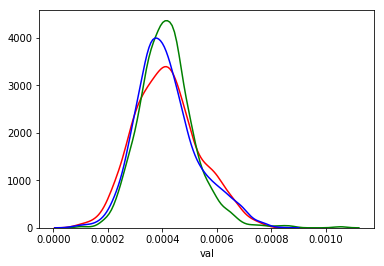

In [59]:
sns.distplot(mam_pagerank['val'], hist=False, color='r')
sns.distplot(jjas_pagerank['val'], hist=False, color='g')
sns.distplot(ond_pagerank['val'], hist=False, color='b')

## Visualizations

In [272]:
# global params for all graphs

graph_params = dict(
    gaussian_filtering=0.6,
    cmap='hot_r'
)

### Pre-Monsoon (MAM)

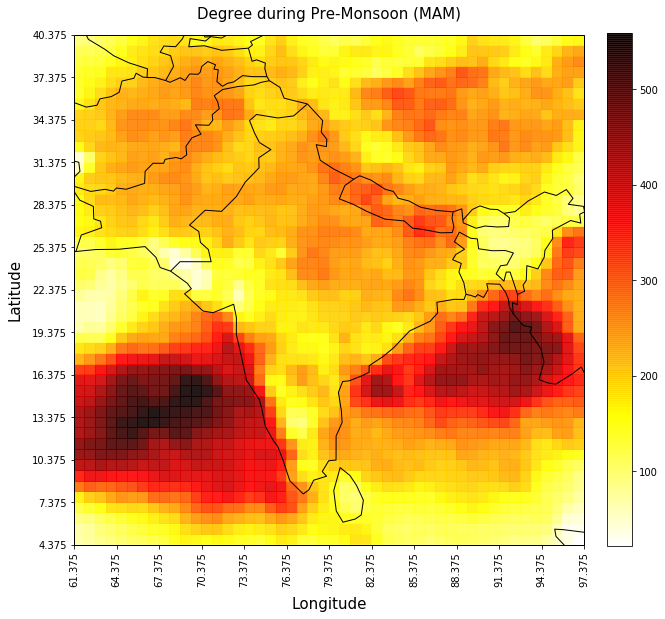

In [313]:
# degree

Visualization.create_cartopy_vis(mam_cent_degree, title='Degree during Pre-Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_mam_deg.png', **graph_params)

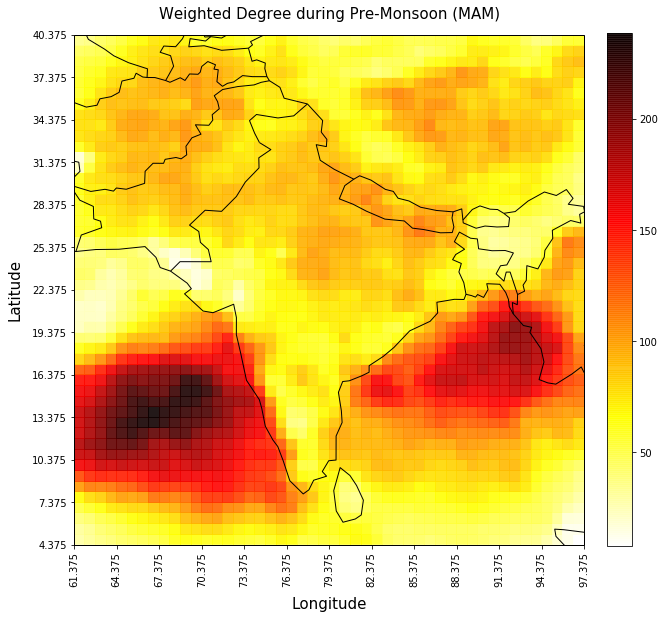

In [314]:
# weighted degree

Visualization.create_cartopy_vis(mam_cent_degree_w, title='Weighted Degree during Pre-Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_mam_deg_weighted.png', **graph_params)

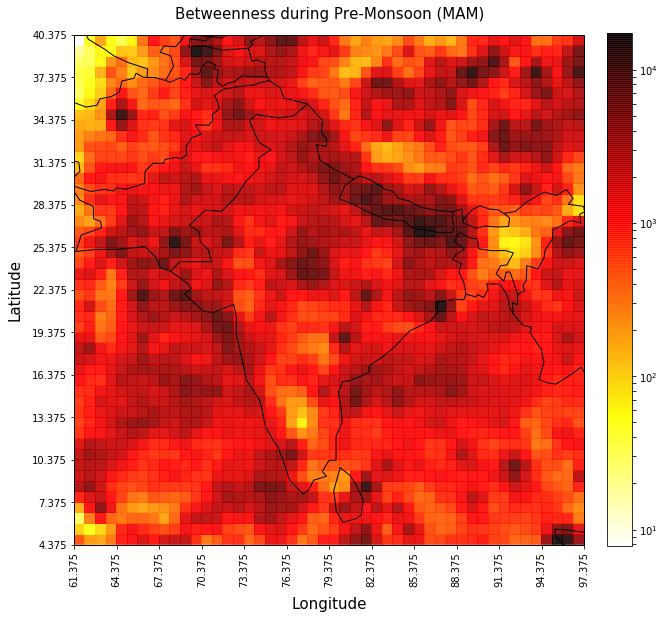

In [315]:
# betweenness (log normalized)

Visualization.create_cartopy_vis(mam_cent_between, log_norm=True, title='Betweenness during Pre-Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_mam_btw.png', **graph_params)

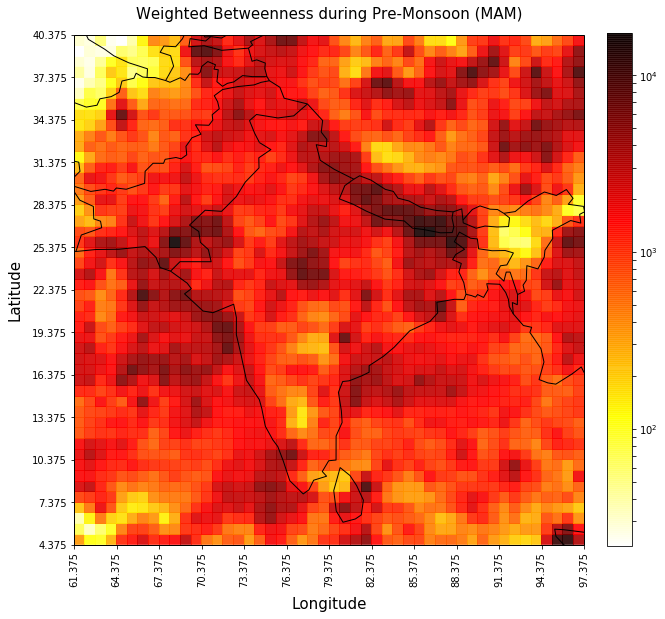

In [316]:
# weighted betweenness (log normalized)

Visualization.create_cartopy_vis(mam_cent_between_w, log_norm=True, title='Weighted Betweenness during Pre-Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_mam_btw_weighted.png', **graph_params)

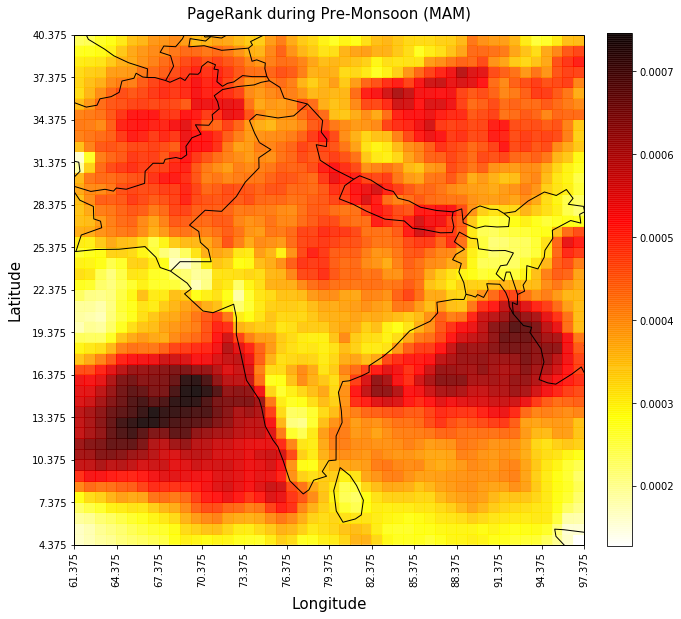

In [317]:
# pagerank

Visualization.create_cartopy_vis(mam_pagerank, title='PageRank during Pre-Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_mam_pr.png', **graph_params)

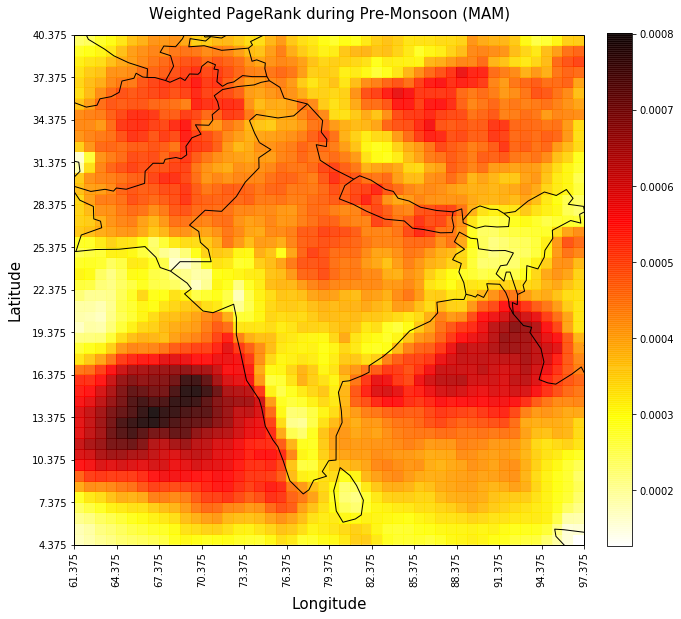

In [318]:
# weighted pagerank

Visualization.create_cartopy_vis(mam_pagerank_w, title='Weighted PageRank during Pre-Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_mam_pr_weighted.png', **graph_params)

### Monsoon (JJAS)

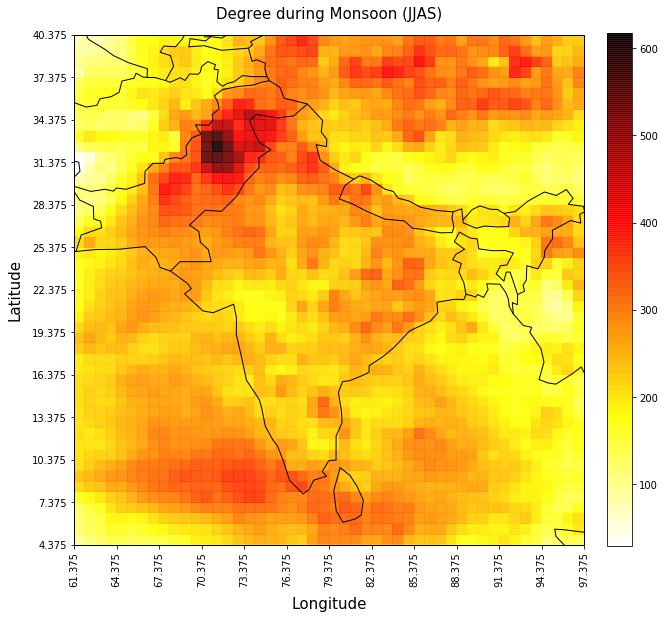

In [319]:
Visualization.create_cartopy_vis(jjas_cent_degree, title='Degree during Monsoon (JJAS)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_jjas_deg.png', **graph_params)

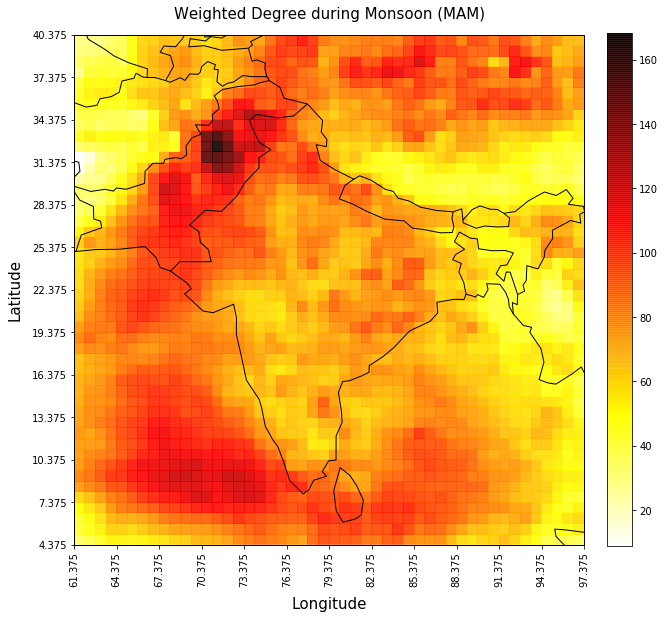

In [320]:
Visualization.create_cartopy_vis(jjas_cent_degree_w, title='Weighted Degree during Monsoon (MAM)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_jjas_deg_weighted.png', **graph_params)

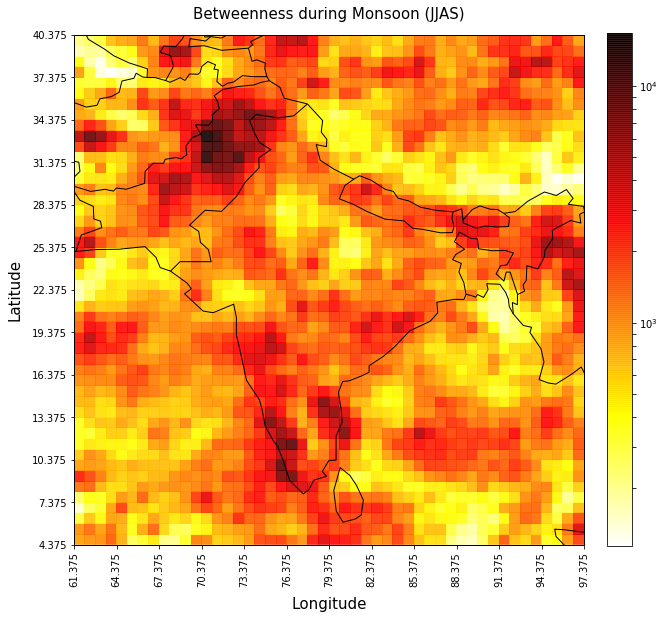

In [321]:
Visualization.create_cartopy_vis(jjas_cent_between, log_norm=True, title='Betweenness during Monsoon (JJAS)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_jjas_btw.png', **graph_params)

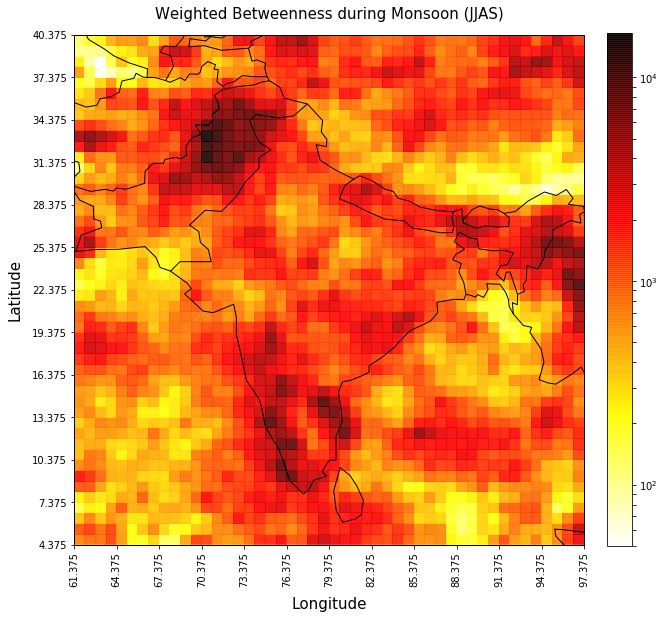

In [322]:
Visualization.create_cartopy_vis(jjas_cent_between_w, log_norm=True, title='Weighted Betweenness during Monsoon (JJAS)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_jjas_btw_weighted.png', **graph_params)

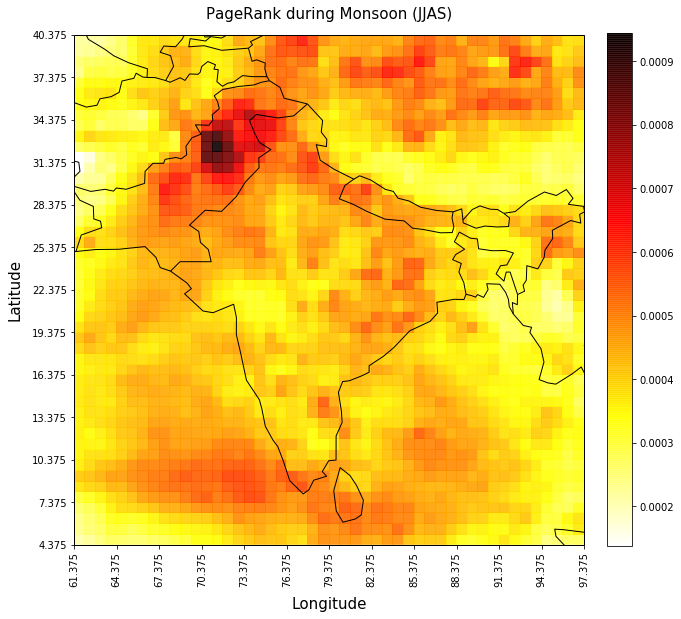

In [323]:
Visualization.create_cartopy_vis(jjas_pagerank, title='PageRank during Monsoon (JJAS)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_jjas_pr.png', **graph_params)

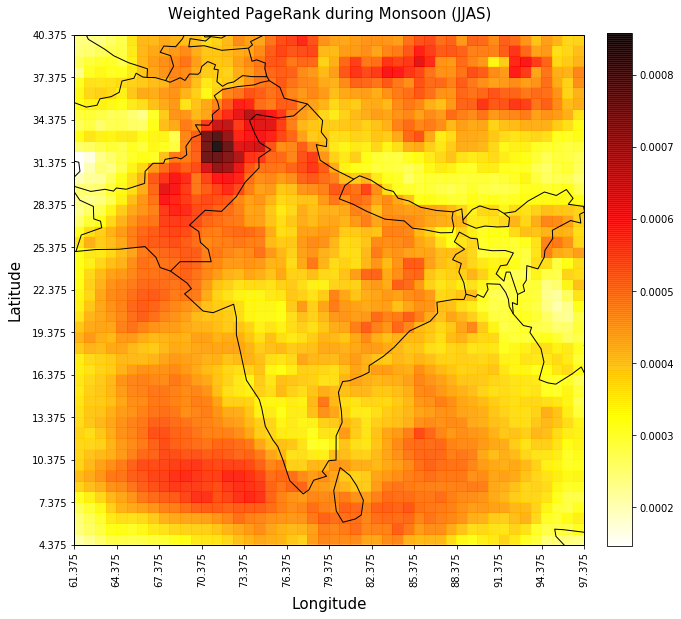

In [324]:
Visualization.create_cartopy_vis(jjas_pagerank_w, title='Weighted PageRank during Monsoon (JJAS)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_jjas_pr_weighted.png', **graph_params)

### Post-Monsoon (OND)

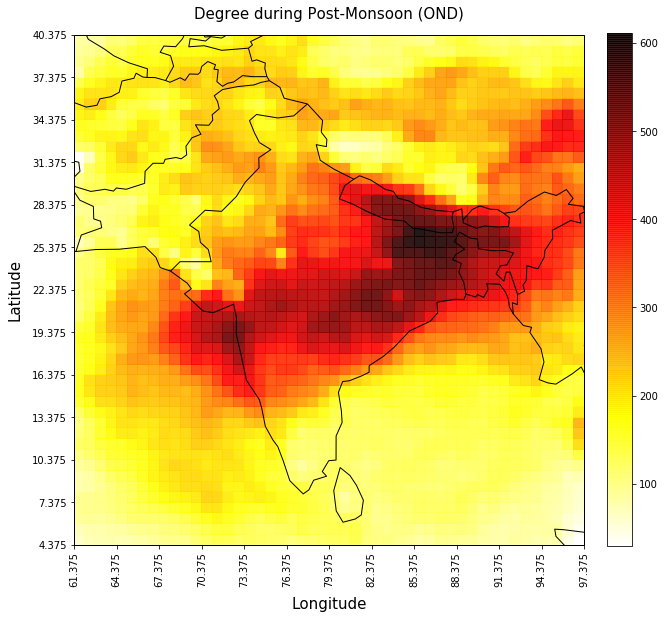

In [325]:
Visualization.create_cartopy_vis(ond_cent_degree, title='Degree during Post-Monsoon (OND)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_ond_deg.png', **graph_params)

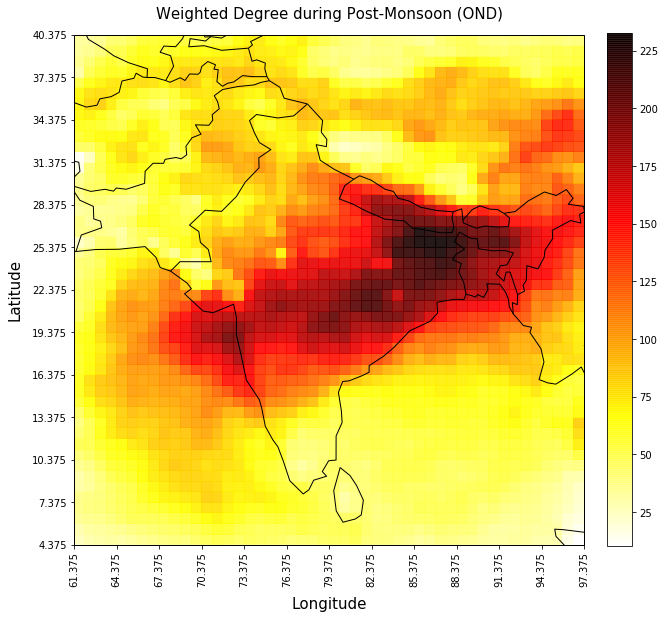

In [327]:
Visualization.create_cartopy_vis(ond_cent_degree_w, title='Weighted Degree during Post-Monsoon (OND)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_ond_deg_weighted.png', **graph_params)

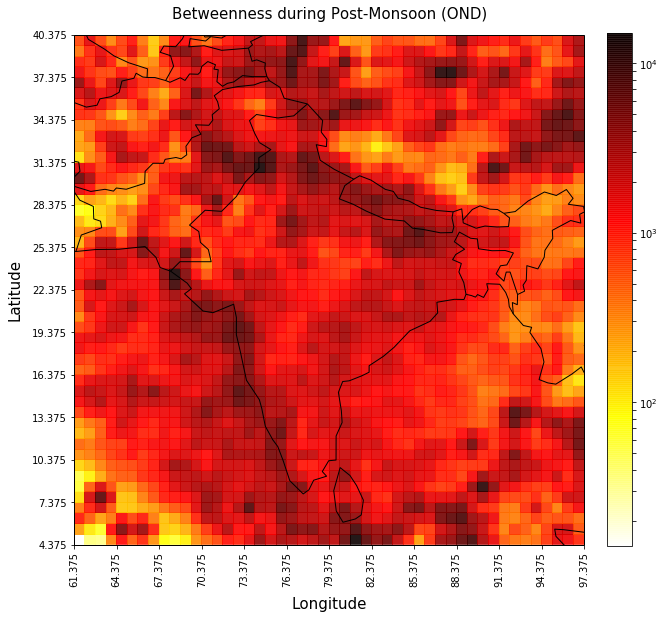

In [328]:
# ond_cent_between_log = ond_cent_between.copy()
# ond_cent_between_log['val'] = np.log(ond_cent_between_log['val'])
Visualization.create_cartopy_vis(ond_cent_between, log_norm=True, title='Betweenness during Post-Monsoon (OND)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_ond_btw.png', **graph_params)

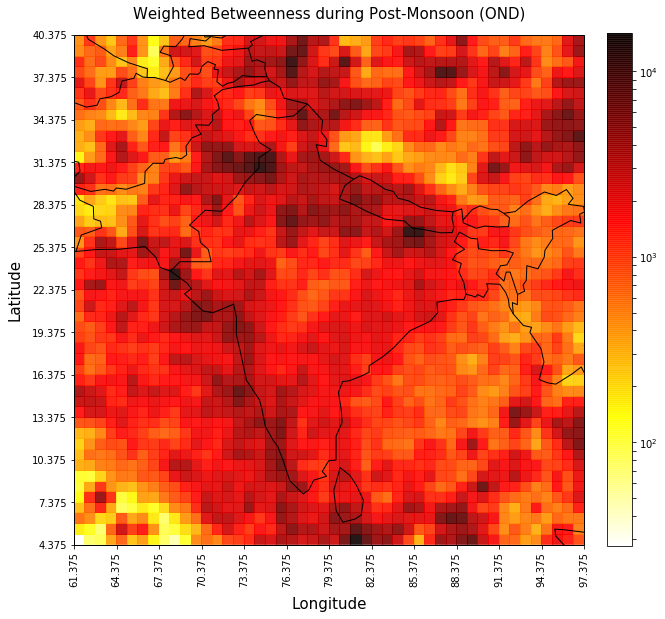

In [332]:
# ond_cent_between_w_log = ond_cent_between_w.copy()
# ond_cent_between_w_log['val'] = np.log(ond_cent_between_w_log['val'])
Visualization.create_cartopy_vis(ond_cent_between_w, log_norm=True, title='Weighted Betweenness during Post-Monsoon (OND)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_ond_btw_weighted.png', **graph_params)

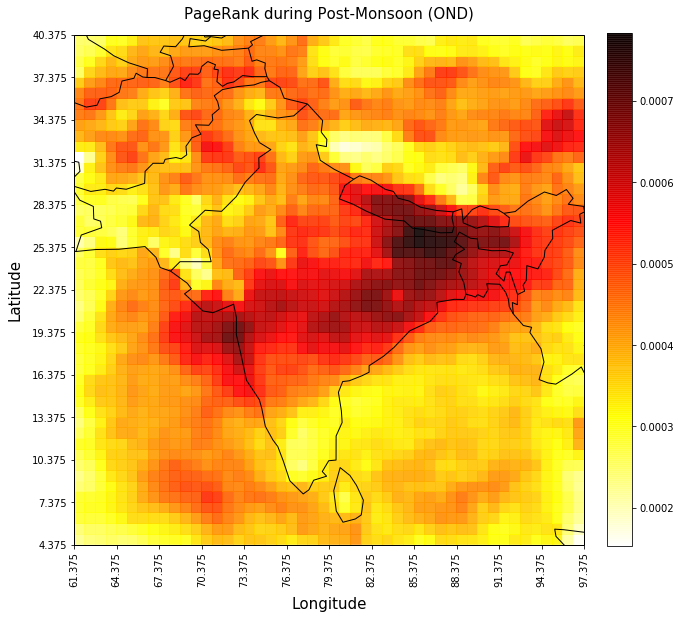

In [330]:
Visualization.create_cartopy_vis(ond_pagerank, title='PageRank during Post-Monsoon (OND)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_ond_pr.png', **graph_params)

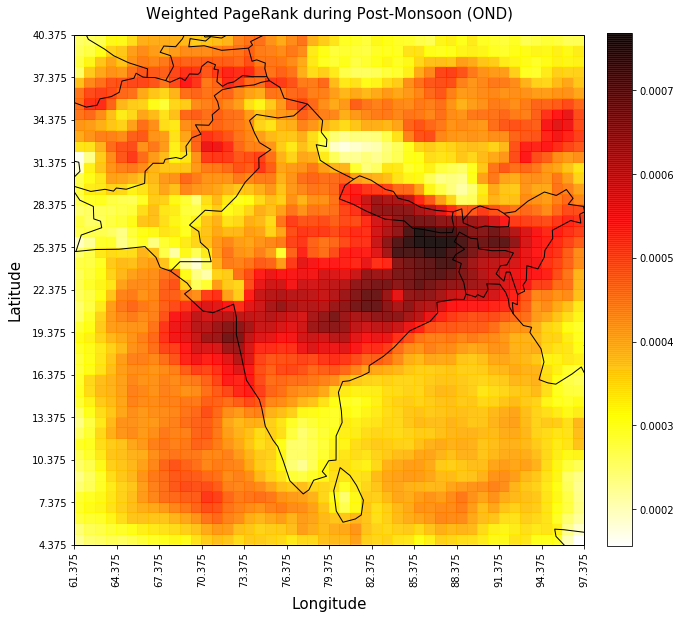

In [331]:
Visualization.create_cartopy_vis(ond_pagerank_w, title='Weighted PageRank during Post-Monsoon (OND)', filename=f'output/sync_{AGGREGATION_RESOLUTION}_ond_pr_weighted.png', **graph_params)

### Overview

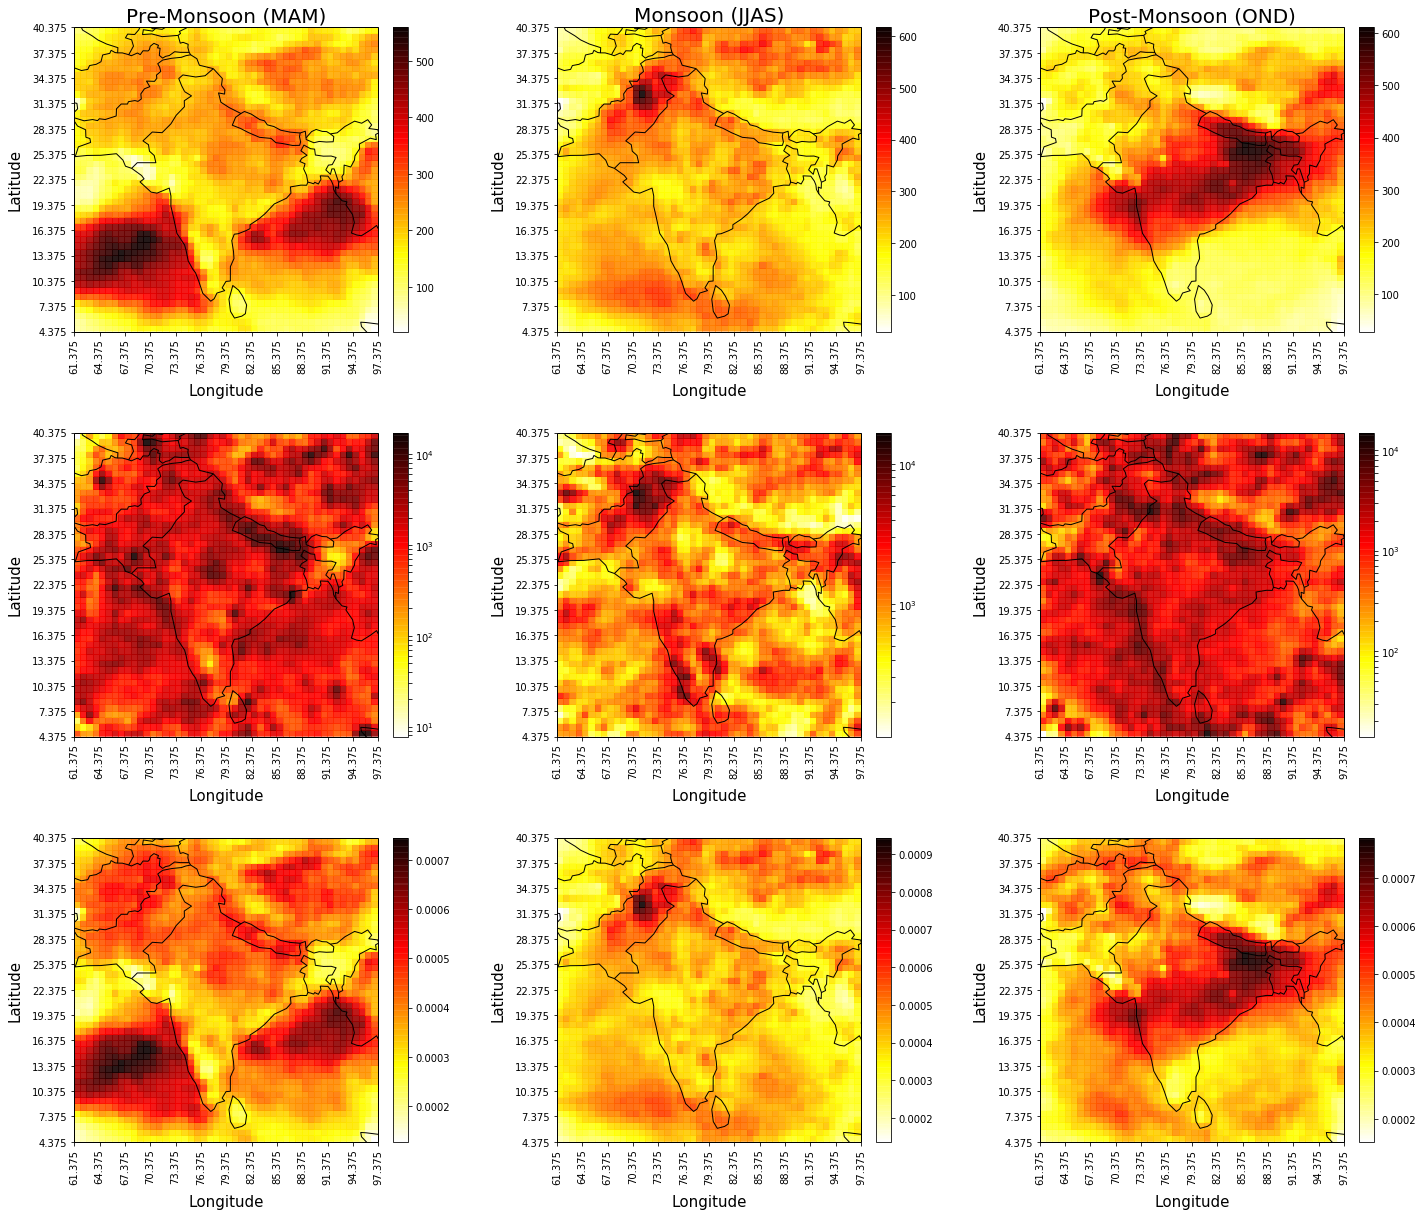

In [308]:
fig, axes = plt.subplots(3, 3, figsize=(20, 17), subplot_kw=dict(projection=ccrs.PlateCarree()))

axes[0, 0].set_title('Pre-Monsoon (MAM)', size=20)
axes[0, 1].set_title('Monsoon (JJAS)', size=20)
axes[0, 2].set_title('Post-Monsoon (OND)', size=20)
# axes[0, 0].set_ylabel('Degree', rotation=0, size=20)
# axes[1, 0].set_ylabel('Betweenness', rotation=0, size=20)
# axes[2, 0].set_ylabel('PageRank', rotation=0, size=20)

Visualization.create_cartopy_vis(mam_cent_degree, ax=axes[0, 0], **graph_params)
Visualization.create_cartopy_vis(jjas_cent_degree, ax=axes[0, 1], **graph_params)
Visualization.create_cartopy_vis(ond_cent_degree, ax=axes[0, 2], **graph_params)

Visualization.create_cartopy_vis(mam_cent_between, log_norm=True, ax=axes[1, 0], **graph_params)
Visualization.create_cartopy_vis(jjas_cent_between, log_norm=True, ax=axes[1, 1], **graph_params)
Visualization.create_cartopy_vis(ond_cent_between, log_norm=True, ax=axes[1, 2], **graph_params)

Visualization.create_cartopy_vis(mam_pagerank, ax=axes[2, 0], **graph_params)
Visualization.create_cartopy_vis(jjas_pagerank, ax=axes[2, 1], **graph_params)
Visualization.create_cartopy_vis(ond_pagerank, ax=axes[2, 2], **graph_params)

# nx.draw_spring(mam_graph, ax=axes[3, 0], node_size=0.3, width=0.01)
# nx.draw_spring(jjas_graph, ax=axes[3, 1], node_size=0.3, width=0.01)
# nx.draw_spring(ond_graph, ax=axes[3, 2], node_size=0.3, width=0.01)

# Visualization.create_cartopy_vis(msl_first, ax=axes[0, 0], title='On 01.03', vis_type='contour', cmap='coolwarm', clabel='hPa')

# supttl = fig.suptitle('Average Mean Sea-Level Pressure (ERA)', size=30)
# supttl.set_position([0.5, 1.02])
plt.tight_layout(w_pad=3.0, h_pad=3.0)
plt.savefig(f'output/event_sync_{AGGREGATION_RESOLUTION}-{EE_QUANTILE}.png', bbox_inches='tight')

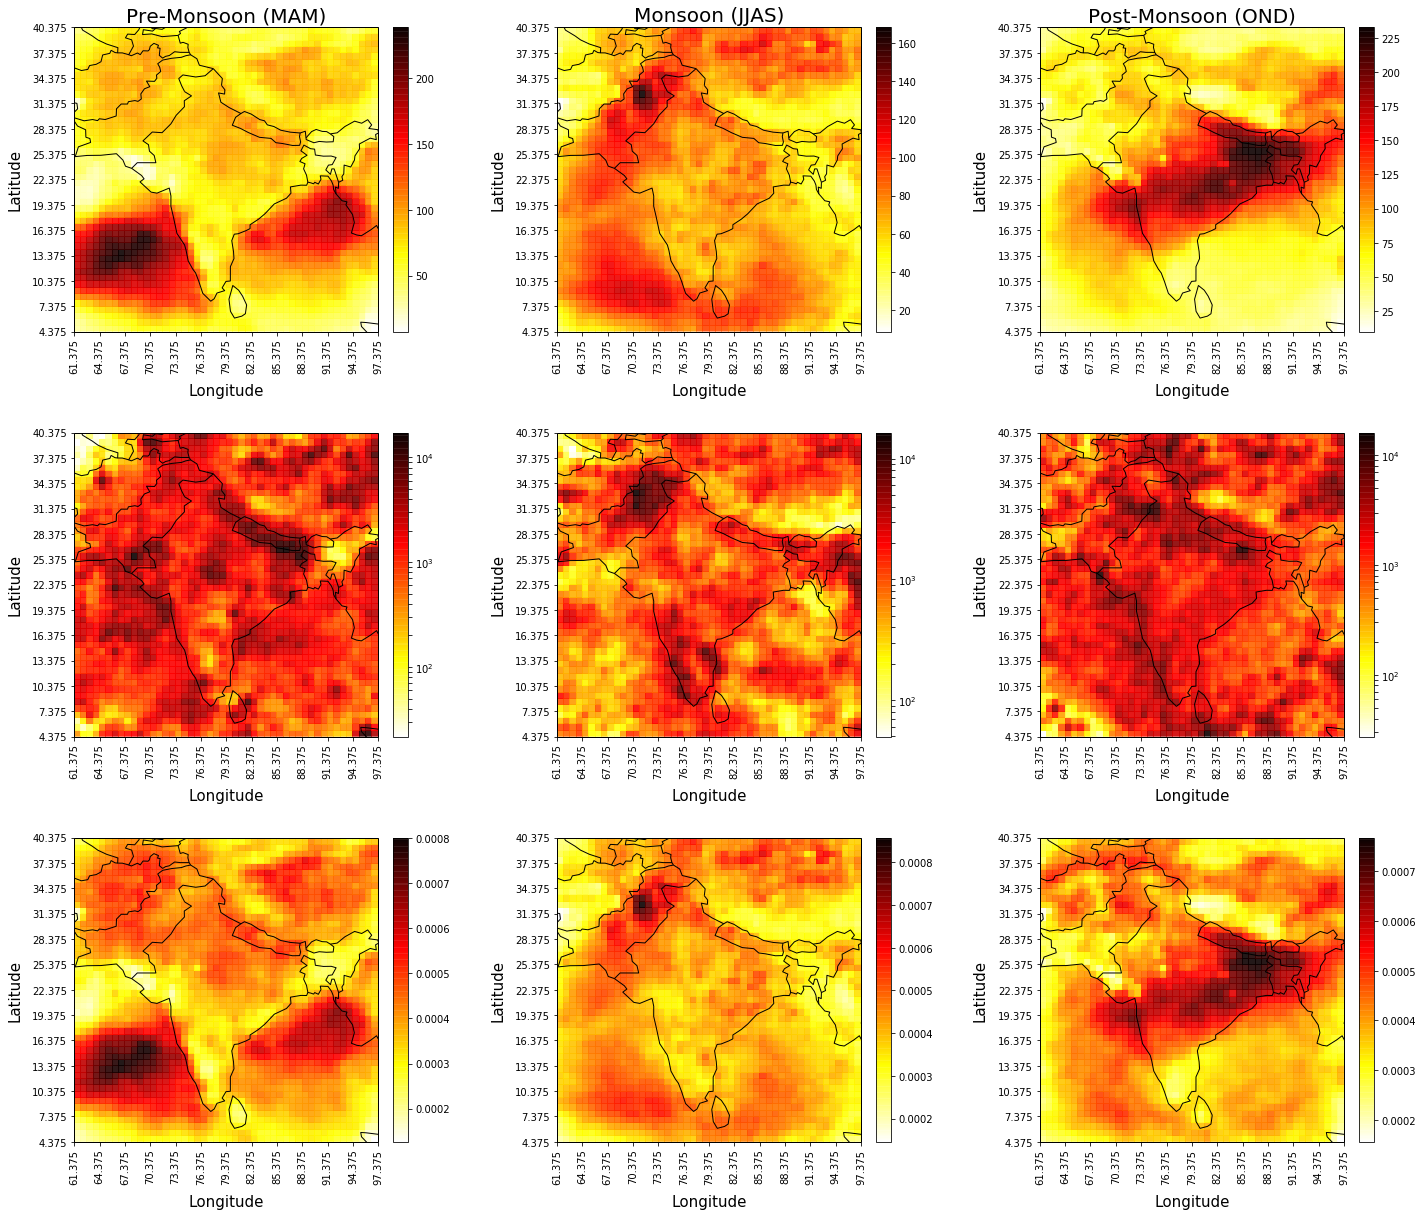

In [309]:
fig, axes = plt.subplots(3, 3, figsize=(20, 17), subplot_kw=dict(projection=ccrs.PlateCarree()))

axes[0, 0].set_title('Pre-Monsoon (MAM)', size=20)
axes[0, 1].set_title('Monsoon (JJAS)', size=20)
axes[0, 2].set_title('Post-Monsoon (OND)', size=20)
# axes[0, 0].set_ylabel('Degree', rotation=0, size=20)
# axes[1, 0].set_ylabel('Betweenness', rotation=0, size=20)
# axes[2, 0].set_ylabel('PageRank', rotation=0, size=20)

Visualization.create_cartopy_vis(mam_cent_degree_w, ax=axes[0, 0], **graph_params)
Visualization.create_cartopy_vis(jjas_cent_degree_w, ax=axes[0, 1], **graph_params)
Visualization.create_cartopy_vis(ond_cent_degree_w, ax=axes[0, 2], **graph_params)

Visualization.create_cartopy_vis(mam_cent_between_w, ax=axes[1, 0], log_norm=True, **graph_params)
Visualization.create_cartopy_vis(jjas_cent_between_w, ax=axes[1, 1], log_norm=True, **graph_params)
Visualization.create_cartopy_vis(ond_cent_between_w, ax=axes[1, 2], log_norm=True, **graph_params)

Visualization.create_cartopy_vis(mam_pagerank_w, ax=axes[2, 0], **graph_params)
Visualization.create_cartopy_vis(jjas_pagerank_w, ax=axes[2, 1], **graph_params)
Visualization.create_cartopy_vis(ond_pagerank_w, ax=axes[2, 2], **graph_params)

# nx.draw_spring(mam_graph, ax=axes[3, 0], node_size=0.3, width=0.01)
# nx.draw_spring(jjas_graph, ax=axes[3, 1], node_size=0.3, width=0.01)
# nx.draw_spring(ond_graph, ax=axes[3, 2], node_size=0.3, width=0.01)

# Visualization.create_cartopy_vis(msl_first, ax=axes[0, 0], title='On 01.03', vis_type='contour', cmap='coolwarm', clabel='hPa')

# supttl = fig.suptitle('Average Mean Sea-Level Pressure (ERA)', size=30)
# supttl.set_position([0.5, 1.02])
plt.tight_layout(w_pad=3.0, h_pad=3.0)
plt.savefig(f'output/event_sync_{AGGREGATION_RESOLUTION}-{EE_QUANTILE}_weighted.png', bbox_inches='tight')